In [86]:
# the document can introduce classifier to generate the final result


In [87]:
# All import
import cv2
import numpy as np

In [88]:
def slide_window(window_size, overlap):
    final_list = []
    for x in range(0, 720 - int(window_size[0] / 2) + 1, int(window_size[0] / 2 * overlap)):
        for y in range(0, 1280 - int(window_size[1] / 2) + 1, int(window_size[1] / 2 * overlap)):
            final_list.append((x, y))
    return final_list

In [89]:
# input img RGB
# def img_with_window(img_path, center):
#     img = cv2.imread(img_path)
#     img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     (left, top) = (center[1], center[0])
#     (right, bottom) = (center[1] + 100, center[0] + 100)
#     roi_img = img_RGB[top:bottom, left:right]
#     return extractor(roi_img)

def img_with_window_SVM(img_path, center):
    img = cv2.imread(img_path)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (left, top) = (center[1], center[0])
    (right, bottom) = (center[1] + 100, center[0] + 100)
    roi_img = img_RGB[top:bottom, left:right]
    gray_img = cv2.cvtColor(roi_img, cv2.COLOR_RGB2GRAY)
    final_img = cv2.resize(gray_img, (100, 100), interpolation=cv2.INTER_CUBIC)
    features, hog_img = hog(final_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True,
                            feature_vector=False)
    return hog_img.flatten()

In [90]:
from PIL import Image, ImageDraw

# def draw_starfish(img, img_metric, center):
#     (left, top) = (center[1], center[0])
#     (right, bottom) = (center[1] + 40, center[0] + 40)
#     draw_img = cv2.rectangle(img, (left, top), (right, bottom), (255, 0, 0), 2)
#     img_metric = cv2.rectangle(img_metric, (left, top), (right, bottom), (255, 255, 255), -1)
#     return draw_img, img_metric
def draw_starfish(img, center):
    (left, top) = (center[1], center[0])
    (right, bottom) = (center[1] + 50, center[0] + 50)
    draw_img = cv2.rectangle(img, (left, top), (right, bottom), (255, 0, 0), 2)
    return draw_img

In [91]:
window_size = (100, 100)
overlap = 0.2
slide_window_list = slide_window(window_size, overlap)

In [92]:
import pickle

with open('.\\clf2.pickle', 'rb') as f:
    clf2 = pickle.load(f)
with open('.\\clf_DT_4000.pickle', 'rb') as f:
    clf_DT_4000 = pickle.load(f)

with open('.\\./clf_SVM_final.pickle', 'rb') as f:
    clf_SVM_final = pickle.load(f)

with open('.\\./clf_DT_final.pickle', 'rb') as f:
    clf_DT_final = pickle.load(f)

In [93]:
from skimage.feature import hog

def computeHOGs(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    final_img = cv2.resize(gray_img, (100, 100), interpolation=cv2.INTER_CUBIC)
    features, hog_img = hog(final_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True,
                            feature_vector=False)
    plt.imshow(hog_img, 'gray')
    return hog_img.flatten()
    # return gradient

# from skimage.feature import hog
def get_color_histo_feature(img):
    img = cv2.resize(img, (10, 10), interpolation=cv2.INTER_CUBIC)
    channel1_hist = np.histogram(img[:, :, 0])
    channel2_hist = np.histogram(img[:, :, 1])
    channel3_hist = np.histogram(img[:, :, 2])
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

def extractor(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    img_features = []
    img_features.append(computeHOGs(img))
    img_features.append(get_color_histo_feature(img))
    return np.concatenate(img_features)

def img_with_window_DT(img_path, center):
    img = cv2.imread(img_path)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (left, top) = (center[1], center[0])
    (right, bottom) = (center[1] + 100, center[0] + 100)
    roi_img = img_RGB[top:bottom, left:right]
    return extractor(roi_img)

100%|██████████| 8432/8432 [14:42<00:00,  9.55it/s]


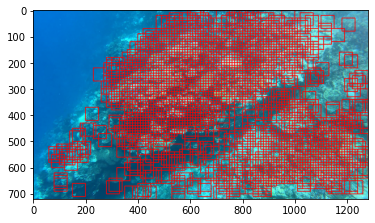

In [94]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
img_path = '.\\tensorflow-great-barrier-reef\\train_images\\video_1\\9114.jpg'
img = cv2.imread(img_path)
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
list_proba = []
# tqdm
max_prob = 0
draw_location_final = []
for i in tqdm(range(len(slide_window_list))):
    gradient_SVM = img_with_window_SVM(img_path, slide_window_list[i])
    prob_data = clf_SVM_final.predict_proba([gradient_SVM])[0]
    gradient_DT = img_with_window_DT(img_path, slide_window_list[i])
    list_proba.append(prob_data[1])
    if prob_data[1] > 0.6 and clf_DT_final.predict([gradient_DT]) == [1] :
        draw_location_final.append(i)
for j in draw_location_final:
    img_RGB = draw_starfish(img_RGB, slide_window_list[j])
plt.imshow(img_RGB)


100%|██████████| 8432/8432 [17:48<00:00,  7.89it/s]


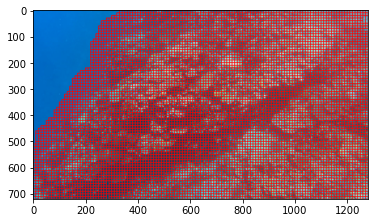

In [95]:
# result only use SVM
img_path = '.\\tensorflow-great-barrier-reef\\train_images\\video_1\\9114.jpg'
img = cv2.imread(img_path)
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
list_proba = []
# tqdm
max_prob = 0
draw_location_SVM = []
for i in tqdm(range(len(slide_window_list))):
    gradient_SVM = img_with_window_SVM(img_path, slide_window_list[i])
    prob_data = clf_SVM_final.predict_proba([gradient_SVM])[0]
    gradient_DT = img_with_window_DT(img_path, slide_window_list[i])
    list_proba.append(prob_data[1])
    if prob_data[1] > 0.6:
        draw_location_SVM.append(i)
for j in draw_location_SVM:
    img_RGB = draw_starfish(img_RGB, slide_window_list[j])
plt.imshow(img_RGB)

100%|██████████| 8432/8432 [22:08<00:00,  6.35it/s] 


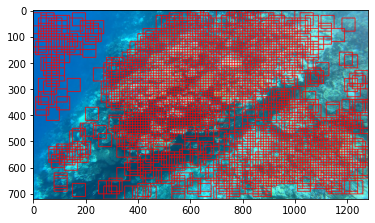

In [96]:
# result only use DT
import matplotlib.pyplot as plt
from tqdm import tqdm

img_path = '.\\tensorflow-great-barrier-reef\\train_images\\video_1\\9114.jpg'
img = cv2.imread(img_path)
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
list_proba = []
# tqdm
max_prob = 0
draw_location_DT = []
for i in tqdm(range(len(slide_window_list))):
    gradient_SVM = img_with_window_SVM(img_path, slide_window_list[i])
    prob_data = clf_SVM_final.predict_proba([gradient_SVM])[0]
    gradient_DT = img_with_window_DT(img_path, slide_window_list[i])
    list_proba.append(prob_data[1])
    if clf_DT_final.predict([gradient_DT]) == [1] :
        draw_location_DT.append(i)
for j in draw_location_DT:
    img_RGB = draw_starfish(img_RGB, slide_window_list[j])
plt.imshow(img_RGB)

In [97]:
def draw_starfish(img, img_metric, center):
    (left, top) = (center[1], center[0])
    (right, bottom) = (center[1] + 40, center[0] + 40)
    draw_img = cv2.rectangle(img, (left, top), (right, bottom), (255, 0, 0), 2)
    img_metric = cv2.rectangle(img_metric, (left, top), (right, bottom), (255, 255, 255), -1)
    return draw_img, img_metric

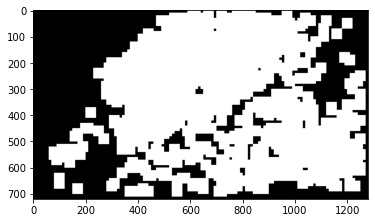

In [98]:
img_metric = np.zeros(img_RGB.shape, np.uint8)
img_metric.fill(0)
for j in draw_location_final:
    img_RGB = draw_starfish(img_RGB, img_metric, slide_window_list[j])[0]
plt.imshow(img_RGB)

for j in draw_location_final:
    img_metric_result = draw_starfish(img_RGB, img_metric, slide_window_list[j])[1]
plt.imshow(img_metric_result)

In [99]:
def spilt_annotations(annotations_str):
    annotations_list = eval(annotations_str)
    for i in range(len(annotations_list)):
        dict_temp = eval(str(annotations_list[i]))
        annotations_list[i] = dict_temp
    return annotations_list

In [100]:
import cv2
import pandas as pd
from tqdm import tqdm
import numpy as np
import pandas
import matplotlib.pyplot as plt

video_file_list = ['video_0', 'video_1', 'video_2']
image_set = '.\\tensorflow-great-barrier-reef\\train_images'
data_set = pd.read_csv(
    '.\\tensorflow-great-barrier-reef\\train.csv')


def get_starfish_image(n):
    image_file = data_set.iloc[n]['video_id']
    image_num = data_set.iloc[n]['video_frame']
    image_path = '.\\tensorflow-great-barrier-reef\\train_images\\' + video_file_list[image_file] + '\\'+ str(image_num) + '.jpg'

    img = cv2.imread(image_path)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_metric = np.zeros(img_RGB.shape, np.uint8)
    img_metric.fill(0)

    list = spilt_annotations(data_set.iloc[n]['annotations'])
    if len(list) != 0:
        for dict in list:
            (left, top) = (dict['x'], dict['y'])
            (right, bottom) = (dict['x'] + dict['width'], dict['y'] + dict['height'])
            draw_starfish = cv2.rectangle(img_RGB, (left, top), (right, bottom), (255, 0, 0), 2)
            img_metric = cv2.rectangle(img_metric, (left, top), (right, bottom), (255, 255, 255), -1)
        plt.imshow(draw_starfish)
    else:
        print('no starfish')
        plt.imshow(img_RGB)
    return img_metric


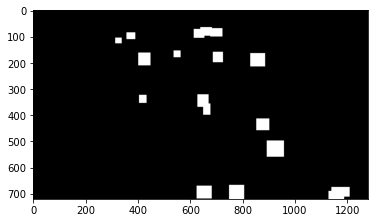

In [101]:
img_metric_true = get_starfish_image(12679) #num range = 0-23500
plt.imshow(img_metric_true)

In [102]:
# img_metric_result
# img_metric_true
# x,y = img_metric_true.shape
TP = 0
FN = 0
FP = 0
for i in range(img_metric_true.shape[0]):
    for j in range(img_metric_true.shape[1]):
        # print(img_metric_true[i][j])
        if img_metric_true[i][j][0]==255 and img_metric[i][j][0]==0:
            FN +=1
        elif img_metric_true[i][j][0]==255 and img_metric[i][j][0]==255:
            TP +=1
        elif img_metric_true[i][j][0]==0 and img_metric[i][j][0]==255:
            FP +=1
beta = 2
print(TP,FN,FP)
F2 = float((1+beta^2)*TP)/float((1+beta^2)*TP+beta^2*FN+FP)
print(float(F2))

23612 8640 544700
0.04090202015652662
